### Tidytuesday #1 The Literary Map


* Clustering: Group the 39 novels into semantic groups
* Semantic Search: Find novels by theme/concept
* Similarity Analysis: See which novels are similar


In [51]:
###   import libraries   ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
import google.generativeai as genai
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10


In [ ]:
## load envs 

genai.configure(api_key=API_KEY)

In [5]:
################################
### ---- data loading   ---- ###
################################
christmas_novel_authors = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-12-30/christmas_novel_authors.csv')
christmas_novel_text = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-12-30/christmas_novel_text.csv')
christmas_novels = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-12-30/christmas_novels.csv')  

In [6]:
### Feature Engineering, Cleaning and data modelling  ###


christmas_novel_text['text'] = christmas_novel_text['text'].replace(r'^\s*$', np.nan, regex=True)
### Join Datasets ###
full_dataset = christmas_novels\
    .merge(christmas_novel_text, left_on='gutenberg_id', 
    right_on='gutenberg_id')\
        .dropna(subset=['text'])\
            .reset_index(drop=True)\
                .merge(christmas_novel_authors,
                left_on='gutenberg_author_id', 
                right_on='gutenberg_author_id', 
                how='left').reset_index(drop=True)

In [7]:
full_dataset['birthdate'] = full_dataset['birthdate'].astype('Int64')
full_dataset['deathdate'] = full_dataset['deathdate'].astype('Int64')
full_dataset['author_age_at_death'] = full_dataset['deathdate'] - full_dataset['birthdate']

In [8]:
def clean_gutenberg_keep_punctuation(text):
    """
    Cleans metadata but keeps punctuation for sentiment analysis
    """
    text = re.sub(r'\[illustration:.*?\]', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\[transcriber\'?s? note:.*?\]', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'-{3,}', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'_', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'"', ' ', text)#* * * * *
    text = re.sub(r'\* \* \* \* \*', ' ', text)
    return text.strip()


In [9]:
grp_novel_text = (
    full_dataset
    .assign(text=full_dataset['text'].fillna('').astype(str)) # Ensures it's a string
    .groupby(['gutenberg_id','title','author','author_age_at_death'])['text']
    .apply(lambda x: ' '.join(s.strip() for s in x if s.strip())) # Cleans each fragment and joins
    .reset_index()
)

grp_novel_text['text'] = grp_novel_text['text'].apply(
    clean_gutenberg_keep_punctuation)


grp_novel_text['text'] = grp_novel_text['text'].str.replace(r'\s+', ' ', regex=True).str.lower().str.strip()
grp_novel_text['word_count'] = grp_novel_text['text'].apply(lambda x: len(x.split()))
grp_novel_text

,gutenberg_id,title,author,author_age_at_death,text,word_count
0,46,A Christmas Carol in Prose; Being a Ghost Stor...,"Dickens, Charles",58,a christmas carol in prose being a ghost story...,28546
1,1902,The Old Peabody Pew: A Christmas Romance of a ...,"Wiggin, Kate Douglas Smith",67,the old peabody pew: a christmas romance of a ...,13388
2,2731,The Christmas Books of Mr. M.A. Titmarsh,"Thackeray, William Makepeace",52,the christmas books of mr. m. a. titmarsh by w...,71611
3,4384,The Lost Word: A Christmas Legend of Long Ago,"Van Dyke, Henry",81,the lost word a christmas legend of long ago b...,9296
4,8694,"The Abbot's Ghost, or Maurice Treherne's Tempt...","Alcott, Louisa May",56,"the abbot's ghost or, maurice treherne's tempt...",25969
5,10707,A Christmas Mystery: The Story of Three Wise Men,"Locke, William John",67,i cannot tell how the truth may be: i say the ...,4993
6,10813,A Versailles Christmas-Tide,"Boyd, Mary Stuart",77,a versailles christmas-tide by mary stuart boy...,19649
7,12881,Mrs. Budlong's Christmas Presents,"Hughes, Rupert",84,mrs. budlong's christmas presents by rupert hu...,13225
8,14534,Christmas with Grandma Elsie,"Finley, Martha",81,christmas with grandma elsie by martha finley ...,67837
9,14606,And Thus He Came: A Christmas Fantasy,"Brady, Cyrus Townsend",59,and thus he came a christmas fantasy by cyrus ...,8831


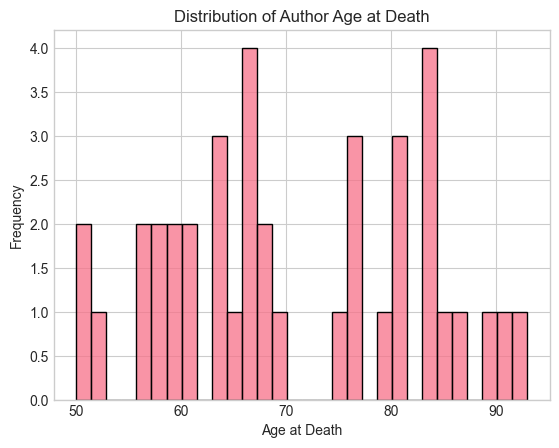

In [10]:
sns.histplot(grp_novel_text['author_age_at_death'].dropna(), bins=30)
plt.title('Distribution of Author Age at Death')
plt.xlabel('Age at Death')
plt.ylabel('Frequency')
plt.show()

In [11]:
grp_novel_text[['author_age_at_death','word_count']].corr()

,author_age_at_death,word_count
author_age_at_death,1.000000,-0.070052
word_count,-0.070052,1.000000


### NLP chapter

In [12]:
def split_text(text, chunk_size=3000, overlap=100):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        
        chunk = text[start:end]
        chunks.append(chunk)
        start += (chunk_size - overlap) 
    return chunks


all_chunks = []

print("Processing books...")
for index, row in grp_novel_text.iterrows():
    book_chunks = split_text(row['text'])
    for i, chunk in enumerate(book_chunks):
        all_chunks.append({
            'book_title': row['title'],
            'author': row['author'],
            'chunk_id': i,
            'text_chunk': chunk
        })

df_chunks = pd.DataFrame(all_chunks)
print(f"Done! From {len(grp_novel_text)} books we created {len(df_chunks)} analyzable fragments.")

Processing books...
Done! From 39 books we created 1867 analyzable fragments.


In [13]:
df_chunks.head()

,book_title,author,chunk_id,text_chunk
0,A Christmas Carol in Prose; Being a Ghost Stor...,"Dickens, Charles",0,a christmas carol in prose being a ghost story...
1,A Christmas Carol in Prose; Being a Ghost Stor...,"Dickens, Charles",1,steel had ever struck out generous fire; secre...
2,A Christmas Carol in Prose; Being a Ghost Stor...,"Dickens, Charles",2,al-box in his own room; and so surely as the c...
3,A Christmas Carol in Prose; Being a Ghost Stor...,"Dickens, Charles",3,"and will do me good; and i say, god bless it! ..."
4,A Christmas Carol in Prose; Being a Ghost Stor...,"Dickens, Charles",4,saries; hundreds of thousands are in want of c...


In [14]:
def get_embedding_safe(text):
    try:
        result = genai.embed_content(
            model="models/text-embedding-004",
            content=text
        )
        return result['embedding']
    except:
        return None

In [15]:
df_chunks['embedding'] = df_chunks['text_chunk'].apply(get_embedding_safe)

In [21]:
df_chunks.dropna(subset=['text_chunk'], inplace=True)

In [22]:
df_chunks

,book_title,author,chunk_id,text_chunk,embedding,cluster,x,y
0,A Christmas Carol in Prose; Being a Ghost Stor...,"Dickens, Charles",0,a christmas carol in prose being a ghost story...,"[0.056152, 0.05288688, 0.008967471, 0.00396456...",3,-39.858910,45.099789
1,A Christmas Carol in Prose; Being a Ghost Stor...,"Dickens, Charles",1,steel had ever struck out generous fire; secre...,"[0.038586136, 0.035533525, 0.007457952, 0.0462...",3,-30.188015,41.022903
2,A Christmas Carol in Prose; Being a Ghost Stor...,"Dickens, Charles",2,al-box in his own room; and so surely as the c...,"[0.03694566, 0.049847398, -0.0012025683, 0.036...",3,-32.558125,38.295307
3,A Christmas Carol in Prose; Being a Ghost Stor...,"Dickens, Charles",3,"and will do me good; and i say, god bless it! ...","[0.048681904, 0.0489011, 0.004128026, 0.023655...",3,-32.097588,37.508595
4,A Christmas Carol in Prose; Being a Ghost Stor...,"Dickens, Charles",4,saries; hundreds of thousands are in want of c...,"[0.038498066, 0.03406468, 0.0016478965, 0.0311...",3,-30.648327,38.345554
...,...,...,...,...,...,...,...,...
1862,Mr. Blake's Walking-Stick: A Christmas Story f...,"Eggleston, Edward",12,"es, and her heart beat every minute more and m...","[0.08837496, 0.004768189, 0.041343022, 0.05535...",1,-44.919872,4.937400
1863,Mr. Blake's Walking-Stick: A Christmas Story f...,"Eggleston, Edward",13,re hungry. and yet mrs. martin had not made up...,"[0.08508592, 0.009639012, -0.0028846208, 0.033...",1,-45.588543,4.890519
1864,Mr. Blake's Walking-Stick: A Christmas Story f...,"Eggleston, Edward",14,he called a great deal. he had been to church ...,"[0.09194495, 0.027044972, 0.0009662602, 0.0457...",1,-45.804218,5.020092
1865,Mr. Blake's Walking-Stick: A Christmas Story f...,"Eggleston, Edward",15,"they talked to harry awhile, without noticing...","[0.028782506, 0.03775296, -0.020464499, 0.0158...",1,-46.062634,3.216906


In [52]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [53]:
matrix = np.vstack(df_chunks['embedding'].values)

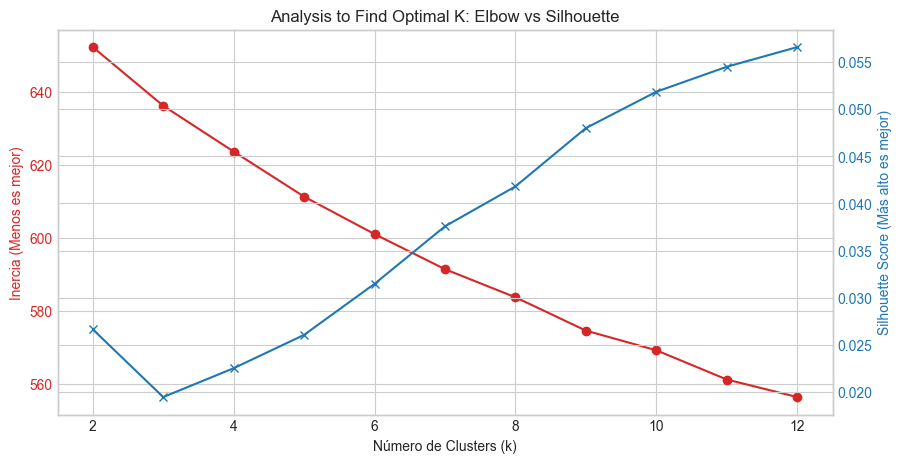

In [54]:
inertia = []
silhouette_scores = []
K_range = range(2, 13) 



for k in K_range:
    kmeans = KMeans(n_clusters=k, 
                    random_state=42, 
                    n_init=10)
    kmeans.fit(matrix)
    
    
    inertia.append(kmeans.inertia_)
    
    
    score = silhouette_score(matrix, kmeans.labels_)
    silhouette_scores.append(score)


fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inercia (Menos es mejor)', color=color)
ax1.plot(K_range, inertia, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx() 
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score (Más alto es mejor)', color=color)
ax2.plot(K_range, silhouette_scores, marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Analysis to Find Optimal K: Elbow vs Silhouette')
plt.grid(True)
plt.show()

Aplicando K-Means con 4 clusters...
Running t-SNE for dimensionality reduction...


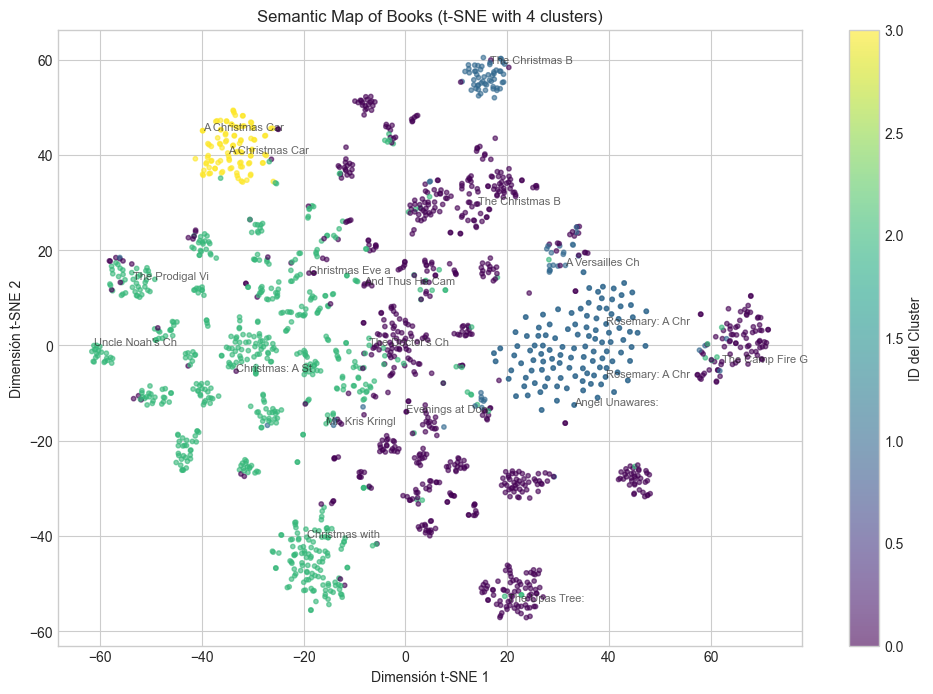

In [55]:
K_OPTIMO = 4

# 3. APLICAR CLUSTERING FINAL
# ===========================
print(f"Aplicando K-Means con {K_OPTIMO} clusters...")
kmeans_final = KMeans(n_clusters=K_OPTIMO, random_state=42, n_init=10)
df_chunks['cluster'] = kmeans_final.fit_predict(matrix)

# 4. 2D VISUALIZATION (t-SNE)
# ===========================
# t-SNE reduces the 768 dimensions to 2 (X and Y) respecting semantic proximity.
print("Running t-SNE for dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='random')
proyeccion_2d = tsne.fit_transform(matrix)

# We save the coordinates in the dataframe to use them later if we want
df_chunks['x'] = proyeccion_2d[:, 0]
df_chunks['y'] = proyeccion_2d[:, 1]

# Graficamos
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_chunks['x'], df_chunks['y'], 
                      c=df_chunks['cluster'], cmap='viridis', alpha=0.6, s=10)
plt.colorbar(scatter, label='ID del Cluster')

# Optional: Label some points to see what they're about
for i in range(0, len(df_chunks), 100): # Label 1 of every 100 points to avoid saturation
    plt.text(df_chunks['x'].iloc[i], df_chunks['y'].iloc[i], 
             df_chunks['book_title'].iloc[i][:15], fontsize=8, alpha=0.7)

plt.title(f'Semantic Map of Books (t-SNE with {K_OPTIMO} clusters)')
plt.xlabel('Dimensión t-SNE 1')
plt.ylabel('Dimensión t-SNE 2')
plt.show()

In [25]:
for k in range(K_OPTIMO):
    print(f"\n--- CLUSTER {k} ---")
    muestras = df_chunks[df_chunks['cluster'] == k].sample(3)
    for texto in muestras['text_chunk']:
        print(f"- {texto[:150]}...")


--- CLUSTER 0 ---
- n. in his own house it had always remained a mute tragedy: each of the two who bore the yoke of it made no willing sign; each turned toward their worl...
- life for evermore; the floor was swept and watered, the lamps were trimmed, fuel was heaped upon the fire; and the warehouse was as snug, and warm, an...
- y. i told her—” “i don’t want to hear your infernal lies.” “but it might be convenient for you to know. i told her,” mcvay chuckled, “that i was emplo...

--- CLUSTER 1 ---
- r away. you mustn't try to hide your feelings from me, dear, the man you mustn't try to hide your feelings from me, dear, the man said. troubles will ...
- s going to be! there never had been one like it before, in the history of the world; but--the best of it was--there was before, in the history of the ...
-  in the sheltered rose-garden of the palace. but with the early nights of january a sudden frost seized the town in its icy grip, and, almost before w...

--- CLUSTER 2 ---
- succe

Why does this make scientific sense?
Internal Heterogeneity: A novel is not a single thing. A Christmas Carol has parts of terror (Marley's ghost), parts of joy (Fezziwig's party) and sad parts (Tiny Tim). If you embed the entire book, you average all that and get a "gray color". By using chunks, you get pure colors.

Resolution: 3000 characters is approximately one page or a short scene. It's the perfect size for the model to understand a complete context (who, what, where) without getting diluted.

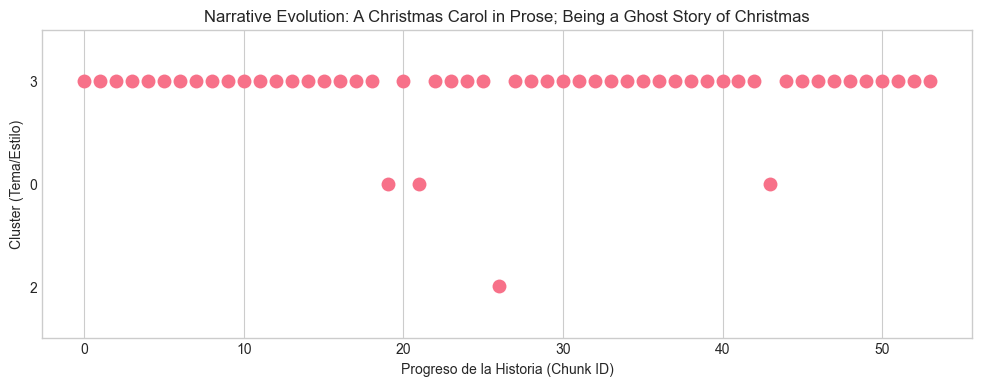

In [56]:
libro = "A Christmas Carol in Prose; Being a Ghost Story of Christmas"
df_libro = df_chunks[df_chunks['book_title'] == libro]

# Plot the evolution of clusters throughout the book
plt.figure(figsize=(12, 4))
sns.stripplot(x=df_libro['chunk_id'], y=df_libro['cluster'].astype(str), jitter=False, size=10)
plt.title(f'Narrative Evolution: {libro}')
plt.xlabel('Progreso de la Historia (Chunk ID)')
plt.ylabel('Cluster (Tema/Estilo)')
plt.grid(True, axis='x')
plt.show()

In [57]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assume you already have 'matrix' with your embeddings (N chunks x 768)
# matrix = np.vstack(df_chunks['embedding'].values)

# 1. Calculate Similarity of All Against All
sim_matrix = cosine_similarity(matrix)

# 2. Build the Graph
G = nx.Graph()
umbral = 0.85 # We only connect if they are VERY similar (adjust based on results)

# We get the pairs that exceed the threshold
filas, columnas = np.where(sim_matrix > umbral)

print("Construyendo red semántica...")
for r, c in zip(filas, columnas):
    if r < c: # Evitar duplicados y auto-conexiones
        libro_a = df_chunks.iloc[r]['book_title']
        libro_b = df_chunks.iloc[c]['book_title']
        
        # VALUE TRICK: We only care about connections BETWEEN different books
        if libro_a != libro_b:
            G.add_edge(r, c, weight=sim_matrix[r, c])
            # We save info in the nodes
            G.nodes[r]['libro'] = libro_a
            G.nodes[c]['libro'] = libro_b

# 3. IMMEDIATE VALUE ANALYSIS

# A) What is the bridge concept? (Edges with most weight)
pares_top = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]
print("\n--- THEMATIC BRIDGES (Identical scenes in different books) ---")
for n1, n2, data in pares_top:
    print(f"\nConexión ({data['weight']:.4f}):")
    print(f"Book 1: {G.nodes[n1]['libro']} -> Text: {df_chunks.iloc[n1]['text_chunk'][:50]}...")
    print(f"Book 2: {G.nodes[n2]['libro']} -> Text: {df_chunks.iloc[n2]['text_chunk'][:50]}...")

# B) Which is the most influential book? (Centrality)
if len(G.nodes) > 0:
    centrality = nx.degree_centrality(G)
    nodo_central = max(centrality, key=centrality.get)
    print(f"\n--- EL CORAZÓN DEL DATASET ---")
    print(f"The most central fragment is from the book: {df_chunks.iloc[nodo_central]['book_title']}")
    print(f"Text: {df_chunks.iloc[nodo_central]['text_chunk']}")

Construyendo red semántica...

--- THEMATIC BRIDGES (Identical scenes in different books) ---

Conexión (0.9727):
Book 1: A Christmas Carol -> Text: t her sitting in the corner with the footstool, or...
Book 2: A Christmas Carol in Prose; Being a Ghost Story of Christmas -> Text:  was on his stool in a jiffy; driving away with hi...

Conexión (0.9638):
Book 1: A Christmas Carol -> Text: wards the door; and he, nothing loath to go, accom...
Book 2: A Christmas Carol in Prose; Being a Ghost Story of Christmas -> Text: of the chaise, the children bade the schoolmaster ...

Conexión (0.9612):
Book 1: A Christmas Carol -> Text: ! repeated scrooge's nephew. but you don't keep it...
Book 2: A Christmas Carol in Prose; Being a Ghost Story of Christmas -> Text: and will do me good; and i say, god bless it! the ...

Conexión (0.9612):
Book 1: A Christmas Carol -> Text:  scarcely seen but once, and who, meeting him in t...
Book 2: A Christmas Carol in Prose; Being a Ghost Story of Christmas -> Te

In [30]:
df_chunks['book_title'].unique()

array(['A Christmas Carol in Prose; Being a Ghost Story of Christmas',
       'The Old Peabody Pew: A Christmas Romance of a Country Church',
       'The Christmas Books of Mr. M.A. Titmarsh',
       'The Lost Word: A Christmas Legend of Long Ago',
       "The Abbot's Ghost, or Maurice Treherne's Temptation: A Christmas Story",
       'A Christmas Mystery: The Story of Three Wise Men',
       'A Versailles Christmas-Tide', "Mrs. Budlong's Christmas Presents",
       'Christmas with Grandma Elsie',
       'And Thus He Came: A Christmas Fantasy',
       'The Burglar and the Blizzard: A Christmas Story',
       'Christmas Outside of Eden', 'The Christmas Angel',
       "Uncle Noah's Christmas Inspiration",
       'The First Christmas Tree: A Story of the Forest',
       'The Upas Tree: A Christmas Story for all the Year',
       'Two Christmas Celebrations', 'The Romance of a Christmas Card',
       'When the Yule Log Burns: A Christmas Story',
       'Rosemary: A Christmas story',
      

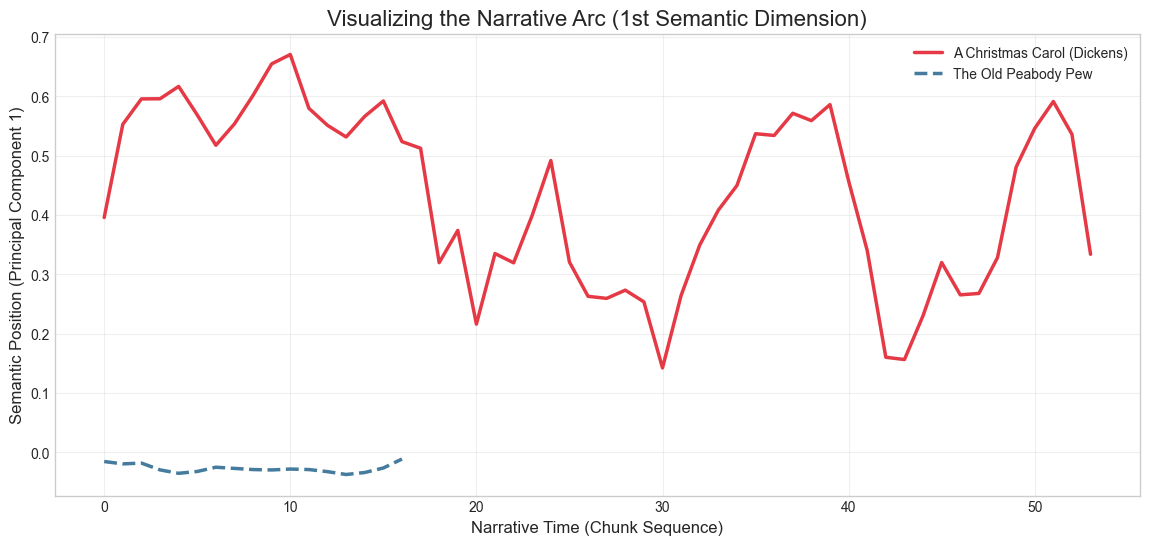

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
tfidf = TfidfVectorizer(stop_words='english', max_features=2000)
tfidf_matrix = tfidf.fit_transform(df_chunks['text_chunk'])
pca = PCA(n_components=50, random_state=42)
vectors = pca.fit_transform(tfidf_matrix.toarray()) # Dense vectors

# Store vectors in dataframe (as if they were the Gemini embeddings)
df_chunks['embedding_sim'] = list(vectors)

# ==============================================================================
# ANALYSIS 1: JAY ALAMMAR STYLE - "THE NARRATIVE TRAJECTORY"
# Projecting the high-dim path of a story onto 1D (Thematic Axis)
# ==============================================================================

# We'll compare "A Christmas Carol" vs another book
book1 = "A Christmas Carol in Prose; Being a Ghost Story of Christmas"
book2 = "Mr. Blake's Walking-Stick: A Christmas Story for Boys and Girls"

# Get chunks for these books
indices1 = df_chunks[df_chunks['book_title'] == book1].index
indices2 = df_chunks[df_chunks['book_title'] == book2].index

# We use the FIRST Principal Component of the WHOLE corpus as the "Main Theme Axis"
# (e.g., Positive vs Negative, or Descriptive vs Dialogue)
y1 = vectors[indices1, 0] # 1st PC
y2 = vectors[indices2, 0]

plt.figure(figsize=(14, 6))

# Smooth the lines for better visualization (Moving Average)
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.plot(smooth(y1, 3), label='A Christmas Carol (Dickens)', linewidth=2.5, color='#E63946')
plt.plot(smooth(y2, 3), label='The Old Peabody Pew', linewidth=2.5, color='#457B9D', linestyle='--')

plt.title('Visualizing the Narrative Arc (1st Semantic Dimension)', fontsize=16)
plt.xlabel('Narrative Time (Chunk Sequence)', fontsize=12)
plt.ylabel('Semantic Position (Principal Component 1)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

Graph retry: 139929 cross-book edges.
Most Central Chunk ID: 1240
Book: Christmas Comes but Once a Year
Showing What Mr. Brown Did, Thought, and Intended to Do, During That Festive Season.
Text Snippet: e; but it did!--firstly, bringing the little merrys, from hope cottage, the tudor lodge, next-door-but-one--master walter merry being the first to ans...


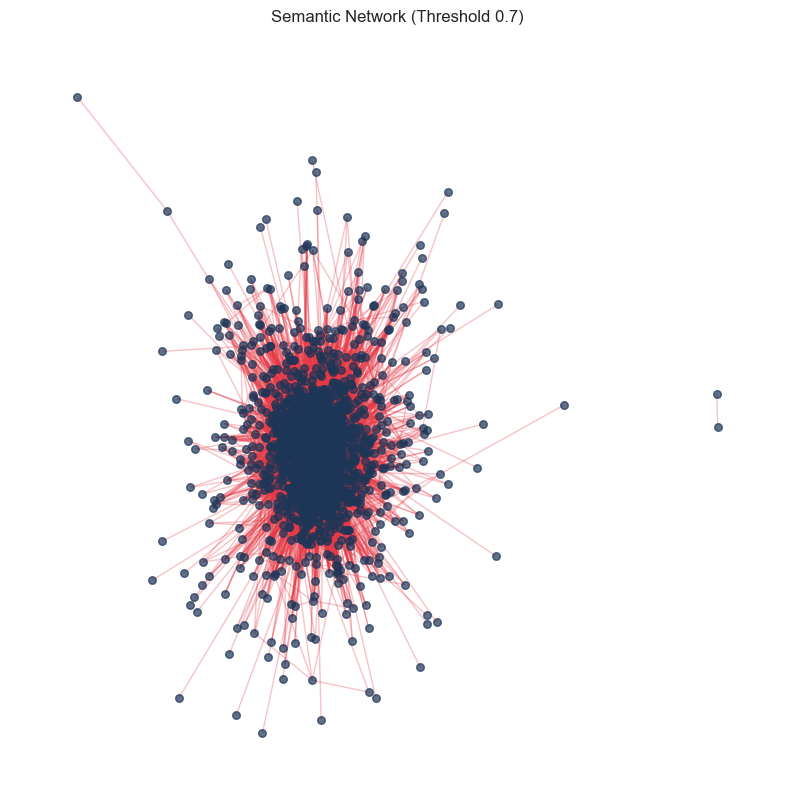

In [59]:
# Retry Graph with lower threshold to ensure we get some connections for the demo
# TF-IDF vectors are sparse/orthogonal, so 0.85 might be too high.
# Let's try 0.5 for the demo.

threshold = 0.7
rows, cols = np.where(sim_matrix > threshold)

G = nx.Graph()
edges_added = 0
for r, c in zip(rows, cols):
    if r < c: 
        if df_chunks.iloc[r]['book_title'] != df_chunks.iloc[c]['book_title']:
            weight = sim_matrix[r, c]
            G.add_edge(r, c, weight=weight)
            edges_added += 1

print(f"Graph retry: {edges_added} cross-book edges.")

if edges_added > 0:
    # Centrality
    centrality = nx.degree_centrality(G)
    most_central_idx = max(centrality, key=centrality.get)
    print(f"Most Central Chunk ID: {most_central_idx}")
    print(f"Book: {df_chunks.iloc[most_central_idx]['book_title']}")
    print(f"Text Snippet: {df_chunks.iloc[most_central_idx]['text_chunk'][:150]}...")
    
    # Plot
    plt.figure(figsize=(10, 10))
    # Filter nodes that actually have edges to reduce noise
    nodes_with_edges = [n for n in G.nodes() if G.degree(n) > 0]
    subG = G.subgraph(nodes_with_edges)
    
    pos = nx.spring_layout(subG, k=0.3)
    nx.draw_networkx_nodes(subG, pos, node_size=30, node_color='#1d3557', alpha=0.7)
    nx.draw_networkx_edges(subG, pos, alpha=0.3, edge_color='#e63946')
    plt.title(f'Semantic Network (Threshold {threshold})')
    plt.axis('off')

In [60]:
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assume you already have 'matrix' with your embeddings (N chunks x 768)
# matrix = np.vstack(df_chunks['embedding'].values)

# 1. Calculate Similarity of All Against All
sim_matrix = cosine_similarity(matrix)

# 2. Build the Graph
G = nx.Graph()
umbral = 0.85 # We only connect if they are VERY similar (adjust based on results)

# We get the pairs that exceed the threshold
filas, columnas = np.where(sim_matrix > umbral)

print("Construyendo red semántica...")
for r, c in zip(filas, columnas):
    if r < c: # Evitar duplicados y auto-conexiones
        libro_a = df_chunks.iloc[r]['book_title']
        libro_b = df_chunks.iloc[c]['book_title']
        
        # VALUE TRICK: We only care about connections BETWEEN different books
        if libro_a != libro_b:
            G.add_edge(r, c, weight=sim_matrix[r, c])
            # We save info in the nodes
            G.nodes[r]['libro'] = libro_a
            G.nodes[c]['libro'] = libro_b

# 3. IMMEDIATE VALUE ANALYSIS

# A) What is the bridge concept? (Edges with most weight)
pares_top = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:5]
print("\n--- THEMATIC BRIDGES (Identical scenes in different books) ---")
for n1, n2, data in pares_top:
    print(f"\nConexión ({data['weight']:.4f}):")
    print(f"Book 1: {G.nodes[n1]['libro']} -> Text: {df_chunks.iloc[n1]['text_chunk'][:50]}...")
    print(f"Book 2: {G.nodes[n2]['libro']} -> Text: {df_chunks.iloc[n2]['text_chunk'][:50]}...")

# B) Which is the most influential book? (Centrality)
if len(G.nodes) > 0:
    centrality = nx.degree_centrality(G)
    nodo_central = max(centrality, key=centrality.get)
    print(f"\n--- EL CORAZÓN DEL DATASET ---")
    print(f"The most central fragment is from the book: {df_chunks.iloc[nodo_central]['book_title']}")
    print(f"Text: {df_chunks.iloc[nodo_central]['text_chunk']}")

Construyendo red semántica...

--- THEMATIC BRIDGES (Identical scenes in different books) ---

Conexión (0.9727):
Book 1: A Christmas Carol -> Text: t her sitting in the corner with the footstool, or...
Book 2: A Christmas Carol in Prose; Being a Ghost Story of Christmas -> Text:  was on his stool in a jiffy; driving away with hi...

Conexión (0.9638):
Book 1: A Christmas Carol -> Text: wards the door; and he, nothing loath to go, accom...
Book 2: A Christmas Carol in Prose; Being a Ghost Story of Christmas -> Text: of the chaise, the children bade the schoolmaster ...

Conexión (0.9612):
Book 1: A Christmas Carol -> Text: ! repeated scrooge's nephew. but you don't keep it...
Book 2: A Christmas Carol in Prose; Being a Ghost Story of Christmas -> Text: and will do me good; and i say, god bless it! the ...

Conexión (0.9612):
Book 1: A Christmas Carol -> Text:  scarcely seen but once, and who, meeting him in t...
Book 2: A Christmas Carol in Prose; Being a Ghost Story of Christmas -> Te

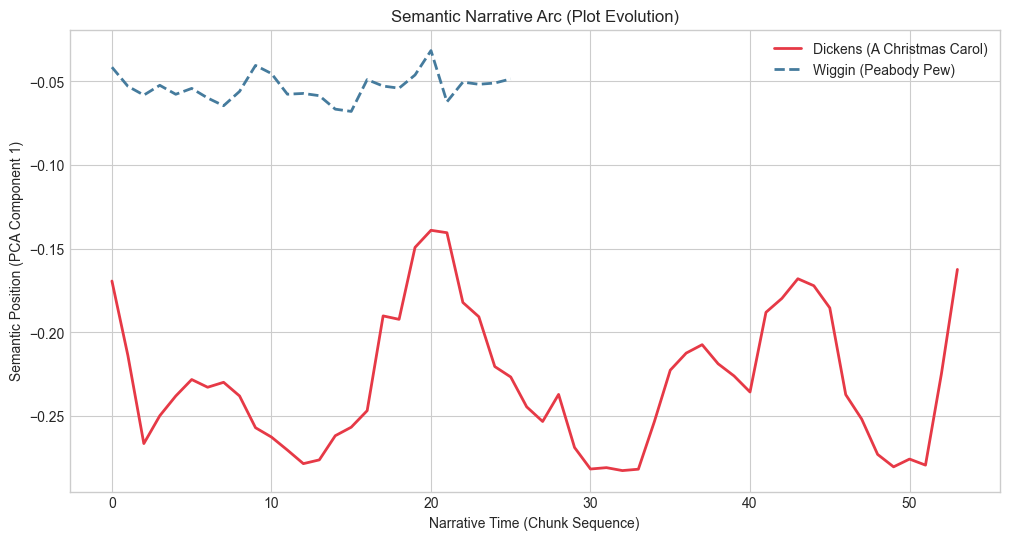

Looking for 'inspirations' and hidden connections...
Found 128 strong connections between different books.


In [61]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

# 1. PREPARE YOUR REAL EMBEDDINGS
# We convert the list of lists into a numpy matrix (Matrix of N chunks x 768 dimensions)
# We assume that df_chunks already has the 'embedding' column generated by Gemini
matrix = np.vstack(df_chunks['embedding'].values)

# ==============================================================================
# ANALYSIS 1: THE NARRATIVE ARC (Vonnegut / Alammar Style)
# ==============================================================================

# We use PCA to reduce the complex 768 dimensions to 1 "Main Dimension"
# This dimension usually captures the largest variance (e.g.: Positive Tone vs Negative)
pca = PCA(n_components=1, random_state=42)
narrative_axis = pca.fit_transform(matrix)

# We save this "narrative position" in the dataframe
df_chunks['narrative_pos'] = narrative_axis

# We plot: Dickens vs Another Book
book1 = "A Christmas Carol in Prose; Being a Ghost Story of Christmas"
book2 = "The Old Peabody Pew: A Christmas Romance of a Country Church" # Or whichever one you want to compare

# Extract the data
y1 = df_chunks[df_chunks['book_title'] == book1]['narrative_pos'].values
y2 = df_chunks[df_chunks['book_title'] == book2]['narrative_pos'].values

# Smoothing function to make the graph readable
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(12, 6))
plt.plot(smooth(y1, 5), label='Dickens (A Christmas Carol)', color='#E63946', linewidth=2)
plt.plot(smooth(y2, 5), label='Wiggin (Peabody Pew)', color='#457B9D', linestyle='--', linewidth=2)
plt.title('Semantic Narrative Arc (Plot Evolution)')
plt.xlabel('Narrative Time (Chunk Sequence)')
plt.ylabel('Semantic Position (PCA Component 1)')
plt.legend()
plt.show()

# ==============================================================================
# ANALYSIS 2: INSPIRATION NETWORK (GRAPHS)
# ==============================================================================

# We calculate real cosine similarity between Gemini vectors
# Note: If there's a lot of data, this consumes memory. For <5000 chunks it's fine.
sim_matrix = cosine_similarity(matrix)

G = nx.Graph()
threshold = 0.88  # Be demanding. We only want VERY strong connections.

rows, cols = np.where(sim_matrix > threshold)

print("Looking for 'inspirations' and hidden connections...")
for r, c in zip(rows, cols):
    if r < c:
        title1 = df_chunks.iloc[r]['book_title']
        title2 = df_chunks.iloc[c]['book_title']
        
        # THE SECRET: We only care about connections between DIFFERENT books
        if title1 != title2:
            weight = sim_matrix[r, c]
            G.add_edge(r, c, weight=weight)
            # We save metadata to analyze later
            G.nodes[r]['book'] = title1
            G.nodes[r]['text'] = df_chunks.iloc[r]['text_chunk']
            G.nodes[c]['book'] = title2
            G.nodes[c]['text'] = df_chunks.iloc[c]['text_chunk']

print(f"Found {G.number_of_edges()} strong connections between different books.")

In [62]:
# Assuming you already have G and sim_matrix calculated
G_limpio = nx.Graph()
edges_added = 0
threshold = 0.60 # A high threshold for quality

# We get rows and columns where there's high similarity
rows, cols = np.where(sim_matrix > threshold)

print("Filtrando conexiones...")
for r, c in zip(rows, cols):
    if r < c: # Evitar duplicados
        # EXTRAEMOS DATOS
        autor1 = df_chunks.iloc[r]['author']
        autor2 = df_chunks.iloc[c]['author']
        
        titulo1 = df_chunks.iloc[r]['book_title']
        titulo2 = df_chunks.iloc[c]['book_title']
        
        # THE GOLDEN RULE: 
        # 1. Different titles (you already had this)
        # 2. Different authors (THIS IS NEW)
        if titulo1 != titulo2 and autor1 != autor2:
            
            weight = sim_matrix[r, c]
            G_limpio.add_edge(r, c, weight=weight)
            
            # We save metadata in the node
            G_limpio.nodes[r]['book'] = titulo1
            G_limpio.nodes[r]['author'] = autor1
            G_limpio.nodes[r]['text'] = df_chunks.iloc[r]['text_chunk']
            
            G_limpio.nodes[c]['book'] = titulo2
            G_limpio.nodes[c]['author'] = autor2
            G_limpio.nodes[c]['text'] = df_chunks.iloc[c]['text_chunk']
            edges_added += 1

print(f"Grafo Limpio: {edges_added} conexiones genuinas entre AUTORES DISTINTOS.")

Filtrando conexiones...
Grafo Limpio: 1293919 conexiones genuinas entre AUTORES DISTINTOS.


In [ ]:
# Let's return to Jay Alammar's approach with this data and these embeddings. What else can we do? Check his blog, learn his method, and see what other techniques we can apply. 

In [40]:
import numpy as np

# 1. Create a mask to ignore what we don't need
# We want: (Autor A != Autor B) Y (Titulo A != Titulo B)
autores = df_chunks['author'].values
titulos = df_chunks['book_title'].values

# Boolean matrix: True where authors are different
mask_autores = autores[:, None] != autores[None, :]
# Boolean matrix: True where titles are different
mask_titulos = titulos[:, None] != titulos[None, :]
# Triangular matrix (only upper part) to not repeat pairs (A-B and B-A)
mask_tri = np.triu(np.ones(sim_matrix.shape), k=1).astype(bool)

# Final Mask: Meets everything at once
mask_final = mask_autores & mask_titulos & mask_tri

# 2. Apply the mask to the similarity matrix
# We put -1 in everything we don't care about so it doesn't show up in the top
sim_matrix_clean = sim_matrix.copy()
sim_matrix_clean[~mask_final] = -1

# 3. Get the indices of the highest values
# We flatten the matrix, sort and take the last (highest) ones
indices_flat = np.argsort(sim_matrix_clean.ravel())[-20:] # We take top 20 to filter manually if needed
top_indices = np.unravel_index(indices_flat, sim_matrix.shape)

print("--- TOP 3 PARES DE INSPIRACIÓN GENUINA ---")
count = 0
for i in range(19, -1, -1): # We go from highest to lowest
    idx1 = top_indices[0][i]
    idx2 = top_indices[1][i]
    score = sim_matrix_clean[idx1, idx2]
    
    if score < 0.8: break # If similarity drops below 0.8, we stop
    
    txt1 = df_chunks.iloc[idx1]['text_chunk']
    txt2 = df_chunks.iloc[idx2]['text_chunk']
    
    # EXTRA FILTER: Avoid detecting indices or catalogs (if the text is pure numbers or very short)
    if len(txt1) > 200 and "Price" not in txt1: 
        count += 1
        print(f"\n#{count} SIMILITUD: {score:.4f}")
        print(f"📖 Book A: {df_chunks.iloc[idx1]['book_title']} (Author: {df_chunks.iloc[idx1]['author']})")
        print(f"📖 Book B: {df_chunks.iloc[idx2]['book_title']} (Author: {df_chunks.iloc[idx2]['author']})")
        print(f"🔍 Text A: ...{txt1[:150]}...")
        print(f"🔍 Text B: ...{txt2[:150]}...")
        print("-" * 60)
        
        if count >= 3: break

--- TOP 3 PARES DE INSPIRACIÓN GENUINA ---

#1 SIMILITUD: 0.8493
📖 Book A: Rosemary: A Christmas story (Author: Williamson, C. N. (Charles Norris))
📖 Book B: Angel Unawares: A Story of Christmas Eve (Author: Williamson, A. M. (Alice Muriel))
🔍 Text A: ... when it was thin, and shut it up when it was very her pink leather bag when it was thin, and shut it up when it was very fat. fat. at the end of the ...
🔍 Text B: ...ing, spoiled-child fashion, for the other side. but angel was clamoring, spoiled-child fashion, for her to say yes, so she said it. conscience and inc...
------------------------------------------------------------

#2 SIMILITUD: 0.8493
📖 Book A: Rosemary: A Christmas story (Author: Williamson, A. M. (Alice Muriel))
📖 Book B: Angel Unawares: A Story of Christmas Eve (Author: Williamson, C. N. (Charles Norris))
🔍 Text A: ... when it was thin, and shut it up when it was very her pink leather bag when it was thin, and shut it up when it was very fat. fat. at the end of the .

Processing 6943 possible connections...
Grafo construido con 256 conexiones de inspiración.


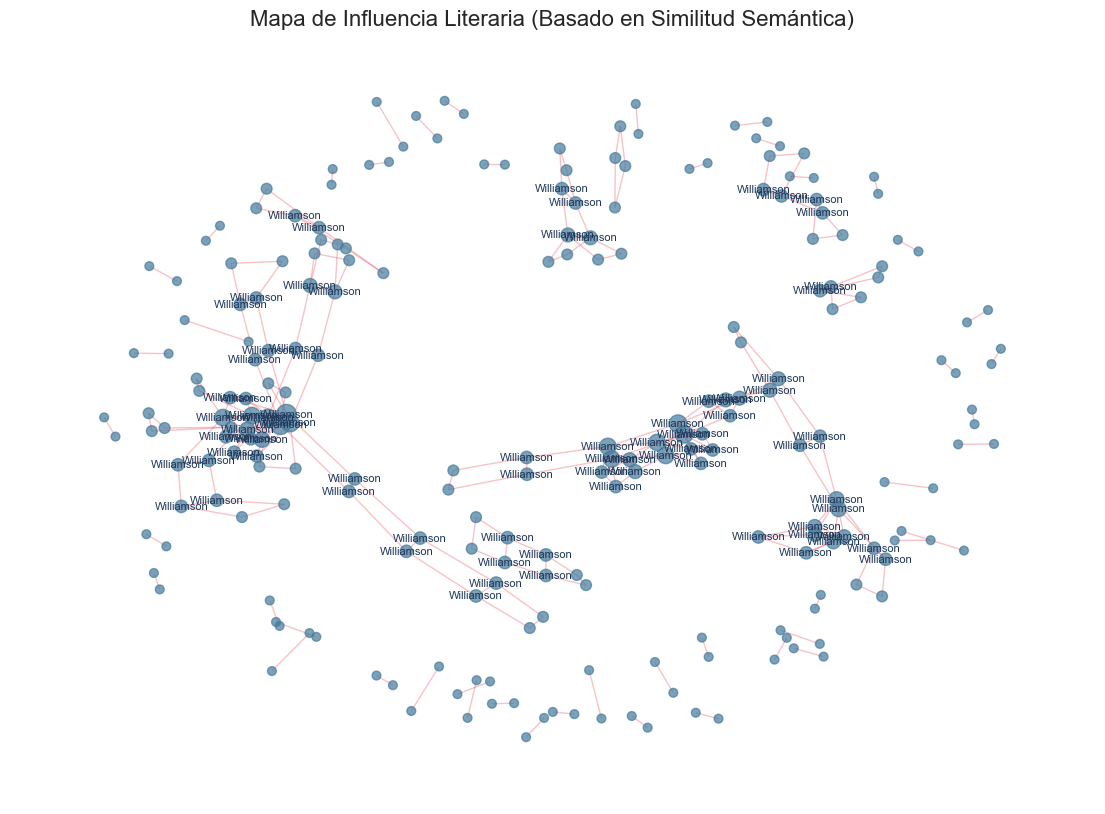

In [48]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# 1. CONFIGURATION
# Assuming 'sim_matrix' already exists (comes from cosine_similarity(matrix))
G_limpio = nx.Graph()
edges_added = 0
threshold = 0.85 # Adjust this: 0.85 is too strict, 0.75 is more permissive

# 2. GRAPH CONSTRUCTION
# We get the coordinates of the matrix where similarity is high
rows, cols = np.where(sim_matrix > threshold)

print(f"Processing {len(rows)} possible connections...")

for r, c in zip(rows, cols):
    if r < c: # Evitamos duplicados (A-B es igual a B-A)
        
        # HERE WE USE METADATA ONLY TO FILTER
        autor1 = df_chunks.iloc[r]['author']
        autor2 = df_chunks.iloc[c]['author']
        titulo1 = df_chunks.iloc[r]['book_title']
        titulo2 = df_chunks.iloc[c]['book_title']
        
        # THE GOLDEN RULE: Solo conectamos autores DISTINTOS
        if autor1 != autor2:
            
            # HERE WE ADD THE "STRENGTH" OF THE CONNECTION (FROM THE EMBEDDING)
            weight = sim_matrix[r, c]
            G_limpio.add_edge(r, c, weight=weight)
            
            # We save the author's name in the node to label the drawing
            # We use a short name so it doesn't clutter the graph
            G_limpio.nodes[r]['label'] = autor1.split(',')[0] 
            G_limpio.nodes[c]['label'] = autor2.split(',')[0]
            
            edges_added += 1

print(f"Grafo construido con {edges_added} conexiones de inspiración.")

# 3. VISUALIZATION (WHAT WAS MISSING)
plt.figure(figsize=(14, 10))

if edges_added > 0:
    # A. We calculate the position of the nodes (Layout)
    # k=0.5 separates nodes so they don't pile up
    pos = nx.spring_layout(G_limpio, k=0.15, iterations=50, seed=42)
    
    # B. Dibujamos los NODOS
    # The size depends on how many connections it has (Importance)
    d = dict(G_limpio.degree)
    node_sizes = [v * 20 + 20 for v in d.values()] # Size multiplier
    nx.draw_networkx_nodes(G_limpio, pos, node_size=node_sizes, node_color='#457b9d', alpha=0.7)
    
    # C. We draw the EDGES (Lines)
    # We only draw a sample if there are too many, to look good
    nx.draw_networkx_edges(G_limpio, pos, alpha=0.3, edge_color='#e63946', width=1)
    
    # D. Dibujamos las ETIQUETAS
    # We only label important nodes (with more than 2 connections) to read well
    nodos_importantes = [n for n, gr in d.items() if gr > 2]
    labels = {n: G_limpio.nodes[n]['label'] for n in nodos_importantes}
    nx.draw_networkx_labels(G_limpio, pos, labels, font_size=8, font_color='#1d3557')
    
    plt.title("Literary Influence Map (Based on Semantic Similarity)", fontsize=16)
    plt.axis('off') # Quitar ejes X e Y
    plt.show()
    
else:
    print("No connections found. Try lowering the 'threshold' to 0.70")

Analyzing connections between: ['McIntosh, Maria J. (Maria Jane)', 'Thackeray, William Makepeace', 'Finley, Martha', 'Allen, James Lane', 'Hale, Edward Everett']


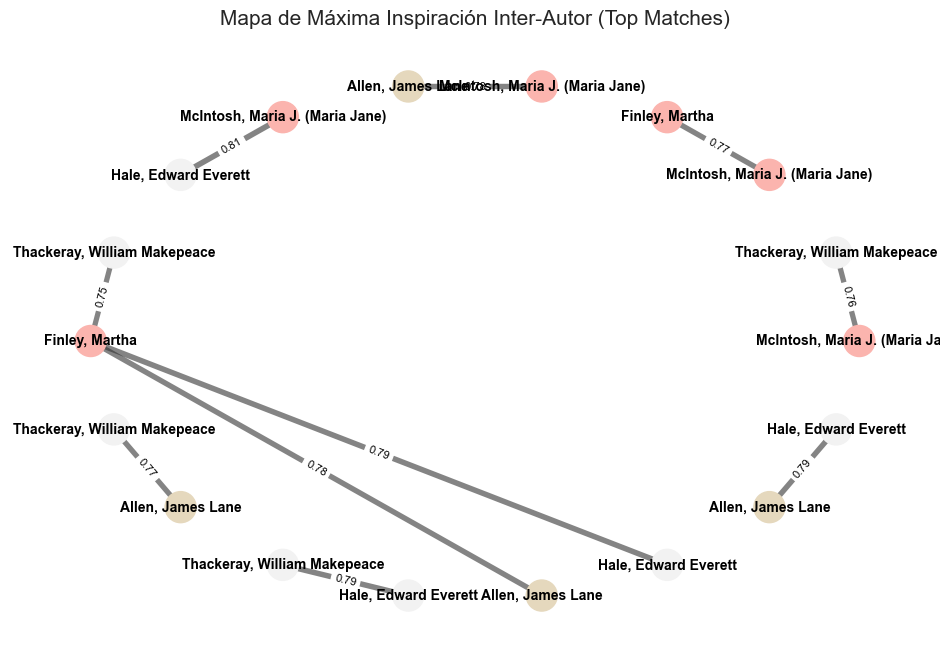


--- EVIDENCIA DE SIMILITUD (TEXTOS REALES) ---

 McIntosh, Maria J. (Maria Jane) <--> Thackeray, William Makepeace (Similitud: 0.7623)
    McIntosh, Maria J. (Maria Jane): d have done had her fingers trembled less. can you sing? elevated above all apprehension by the indi...
    Thackeray, William Makepeace: , struck me with a terror which i cannot describe, and impressed me with the fact of the vast progre...

 McIntosh, Maria J. (Maria Jane) <--> Finley, Martha (Similitud: 0.7740)
    McIntosh, Maria J. (Maria Jane): e interrupted, for all were busy in preparing for this important day. miss donaldson was superintend...
    Finley, Martha: tiful. i'm sure everybody thinks so. don't they, papa? as far as my knowledge goes, he answered, smi...

 McIntosh, Maria J. (Maria Jane) <--> Allen, James Lane (Similitud: 0.7815)
    McIntosh, Maria J. (Maria Jane): could have been so rigid in his observance of a soldier's duty, yet so inexpressibly tender as a man...
    Allen, James Lane: , it 

In [63]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity


top_authors = df_chunks['author'].value_counts().head(5).index.tolist()
df_top = df_chunks[df_chunks['author'].isin(top_authors)].copy()
matrix_top = matrix[df_top.index] 
print(f"Analyzing connections between: {top_authors}")


sim_matrix_top = cosine_similarity(matrix_top)


G = nx.Graph()
connections_found = []

for i in range(len(top_authors)):
    for j in range(i + 1, len(top_authors)):
        auth_A = top_authors[i]
        auth_B = top_authors[j]
        
        idxs_A = np.where(df_top['author'] == auth_A)[0]
        idxs_B = np.where(df_top['author'] == auth_B)[0]
        

        sub_sim = sim_matrix_top[np.ix_(idxs_A, idxs_B)]
        

        max_idx_flat = np.argmax(sub_sim)
        r_local, c_local = np.unravel_index(max_idx_flat, sub_sim.shape)
        
        max_score = sub_sim[r_local, c_local]
        
        
        global_idx_A = idxs_A[r_local]
        global_idx_B = idxs_B[c_local]
        
        
        
        
        node_id_A = df_top.index[global_idx_A]
        G.add_node(node_id_A, label=auth_A, text=df_top.iloc[global_idx_A]['text_chunk'], type='fragment')
        
        
        node_id_B = df_top.index[global_idx_B]
        G.add_node(node_id_B, label=auth_B, text=df_top.iloc[global_idx_B]['text_chunk'], type='fragment')
        
        
        G.add_edge(node_id_A, node_id_B, weight=max_score)
        
        connections_found.append({
            'Auth1': auth_A,
            'Auth2': auth_B,
            'Score': max_score,
            'Text1': df_top.iloc[global_idx_A]['text_chunk'][:100],
            'Text2': df_top.iloc[global_idx_B]['text_chunk'][:100]
        })


plt.figure(figsize=(12, 8))


pos = nx.circular_layout(G)

colors = [hash(G.nodes[n]['label']) for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=500, node_color=colors, cmap=plt.cm.Pastel1)


weights = [G[u][v]['weight'] * 5 for u,v in G.edges()] # Multiply to see them better
nx.draw_networkx_edges(G, pos, width=weights, edge_color='#333333', alpha=0.6)


labels = {n: G.nodes[n]['label'] for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')


edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Maximum Inter-Author Inspiration Map (Top Matches)", fontsize=15)
plt.axis('off')
plt.show()


print("\n--- EVIDENCIA DE SIMILITUD (TEXTOS REALES) ---")
for c in connections_found:
    print(f"\n {c['Auth1']} <--> {c['Auth2']} (Similitud: {c['Score']:.4f})")
    print(f"    {c['Auth1']}: {c['Text1']}...")
    print(f"    {c['Auth2']}: {c['Text2']}...")

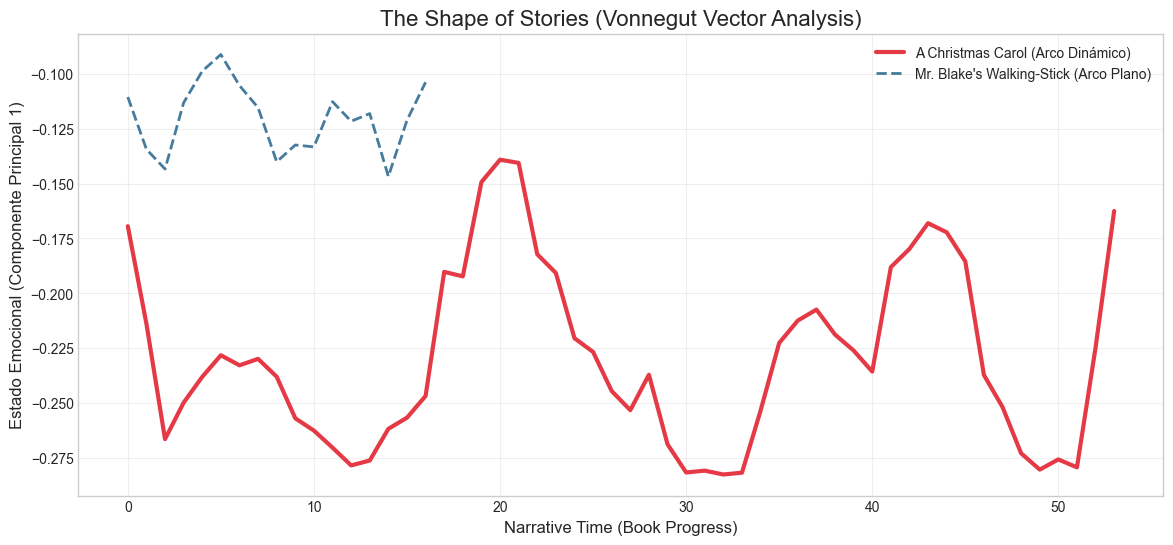

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


matrix = np.vstack(df_chunks['embedding'].values) 


pca = PCA(n_components=1, random_state=42)
narrative_axis = pca.fit_transform(matrix)


df_chunks['vonnegut_axis'] = narrative_axis


book1 = "A Christmas Carol in Prose; Being a Ghost Story of Christmas" # The classic
book2 = "Mr. Blake's Walking-Stick: A Christmas Story for Boys and Girls" # The plane

y1 = df_chunks[df_chunks['book_title'] == book1]['vonnegut_axis'].values
y2 = df_chunks[df_chunks['book_title'] == book2]['vonnegut_axis'].values

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

plt.figure(figsize=(14, 6))


plt.plot(smooth(y1, 5), label='A Christmas Carol (Arco Dinámico)', color='#E63946', linewidth=3)
plt.plot(smooth(y2, 5), label="Mr. Blake's Walking-Stick (Arco Plano)", color='#457B9D', linestyle='--', linewidth=2)

plt.title('The Shape of Stories (Vonnegut Vector Analysis)', fontsize=16)
plt.xlabel('Narrative Time (Book Progress)', fontsize=12)
plt.ylabel('Estado Emocional (Componente Principal 1)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()